<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

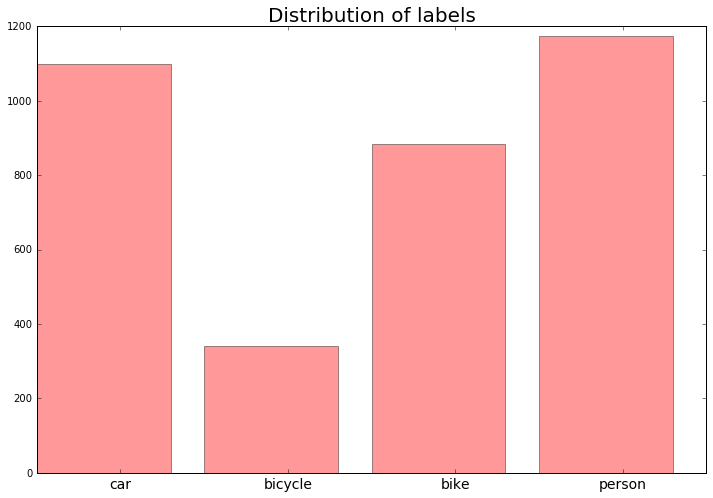

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [77]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [78]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [10]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, self.xi)
        yi = max(0, self.yi)
        xf = min(im.shape[1], self.xf)
        yf = min(im.shape[0], self.yf)
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [82]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= np.float_(new_size[1]) / old_size[1]
        coord[[1,3]] *= np.float_(new_size[0]) / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.size, batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.size - i)):
            objs = annotations[i+j]
            im = imread(objs[0]['image'])
            old_size = im.shape
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4:k*(4 + C)+4 + get_num_from_label(obj['label'])]
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [15]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [68]:
net = {}
net['input'] = InputLayer((None,3,200,200))
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv6'], (2,2))
net['conv7'] = Conv2DLayer(net['pool3'], 64, (3,3))
net['conv8'] = Conv2DLayer(net['conv7'], 64, (3,3))
net['pool4'] = Pool2DLayer(net['conv8'], (2,2))
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 1000)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.8), 1000)
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [69]:
with open('pretrained_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [70]:
S = (6,6)
B = 2
C = 4

In [71]:
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.9), 2048)
net['output'] = DenseLayer(dropout(net['dense1'], p=.9), (S[0] * S[1]) * (5 * B + C), nonlinearity=None)

In [72]:
load_weights = False
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [73]:
num_epochs = 10
batch_size = 25

In [74]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [75]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

In [83]:
train_loss, test_loss = yl.train(
    generate_data_2(train_annotations, C, batch_size=batch_size),
    generate_data_2(test_annotations, C, batch_size=batch_size),
    lr=1e-4,
    epochs=num_epochs
)

Getting cost...
Creating cost variable took 0.6274 seconds
Compiling...


  0%|          | 0/10 [00:00<?, ?it/s]

Compiling functions took 28.1898 seconds
Beginning training...
8.90800415039
8.88185852051
8.76316833496
8.59085571289
8.52597473145
8.26596008301
7.87917785645
7.6279095459
7.47489074707
7.32523681641
6.64062438965
6.57911437988
6.2930065918
5.78154785156
5.91697570801
5.52356567383
4.87327453613
4.98857788086
5.04261779785
4.4865057373
4.38355834961
4.24311553955
4.07792449951
3.75119171143
3.40121032715
3.37861694336
3.23541412354
3.24537658691
3.31247772217
3.26562988281
2.67280548096
2.81644866943
2.53381790161
2.59106750488
2.73771179199
2.26594192505
2.27811477661
2.00360717773
2.15072219849
1.96340957642
1.9320980835
2.05019104004
1.86135925293
1.9807182312
1.85684066772
1.80557662964
1.57621994019
1.55673675537
1.42588516235
1.51307418823
1.22543289185
1.36952941895
1.35118301392
1.10278594971
1.43480926514
1.33928024292
1.42854995728
0.944414901733
1.1179234314
1.10330993652
1.01562545776
1.1944291687
1.13793075562
0.870903167725
0.793045578003
0.952037887573
0.93063293457
0.

 10%|█         | 1/10 [01:53<17:04, 113.88s/it]

Epoch 0
------
Train Loss: 3.3320, Test Loss: 0.0011
0.826868286133
0.840960388184
0.669498138428
0.574172286987
0.607924232483
0.639413414001
0.542108345032
0.778326416016
0.616784553528
0.616260032654
0.550010566711
0.566518287659
0.606245002747
0.477712783813
0.546976203918
0.647412490845
0.560793457031
0.567435112
0.443969078064
0.388695030212
0.422075653076
0.403330421448
0.461433258057
0.381401252747
0.513465003967
0.337099533081
0.457697563171
0.414247055054
0.44605506897
0.41589389801
0.295917034149
0.366164093018
0.439617652893
0.425819206238
0.507759056091
0.355682220459
0.348702087402
0.368435707092
0.425811462402
0.29643579483
0.302527370453
0.354444198608
0.238357753754
0.383065032959
0.272195987701
0.204780540466
0.183510723114
0.238838100433
0.170101184845
0.372603302002
0.361509628296
0.160680541992
0.299331073761
0.363334770203
0.335043067932
0.191066761017
0.272837333679
0.241051864624
0.283553714752
0.264449977875
0.275009555817
0.291921806335
0.262297916412
0.114210

 20%|██        | 2/10 [02:20<11:40, 87.56s/it] 

Epoch 1
------
Train Loss: 0.3934, Test Loss: 0.0000
0.196794528961
0.306709918976
0.0881201934814
0.253370094299
0.247958240509
0.0885727024078
0.197689056396
0.16562543869
0.23379447937
0.223939800262
0.164058132172
0.152877550125
0.196499767303
0.172922000885
0.198908424377
0.112944536209
0.121203374863
0.152092952728
0.13367978096
0.161275291443
0.167119007111
0.183256950378
0.140091609955
0.121100635529
0.201202430725
0.183461456299
0.22273355484
0.113910284042
0.21161441803
0.163494300842
0.120873575211
0.119593677521
0.218929748535
0.186130199432
0.119135541916
0.15069735527
0.103656797409
0.154407129288
0.138011722565
0.0877781486511
0.0692098331451
0.142419624329
0.14111114502
0.151237506866
0.135805206299
0.158062524796
0.105394763947
0.137454900742
0.069197640419
0.041741604805
0.145895328522
0.1292395401
0.0578507566452
0.129060573578
0.0555252456665
0.11465587616
0.105560245514
0.108530578613
0.134880304337
0.120483579636
0.0671479606628
0.0844668769836
0.185887203217
0.08

 30%|███       | 3/10 [02:46<08:04, 69.18s/it]

Epoch 2
------
Train Loss: 0.1418, Test Loss: 0.0000
0.0389072227478
0.0857785129547
0.125161828995
0.0856657886505
0.116461248398
0.176773376465
0.0712697029114
0.109333972931
0.0611736869812
0.0926529693604
0.167919254303
0.0717687797546
0.118633260727
0.0674061965942
0.0765395641327
0.070358300209
0.0960862350464
0.0840421962738
0.0857677650452
0.0920015907288
0.166131153107
0.131635150909
0.0839050674438
0.108291854858
0.0558536624908
0.0846696281433
0.0751909065247
0.107146348953
0.0971059036255
0.0148108506203
0.0637228107452
0.0675875616074
0.040855255127
0.0667178726196
0.0467732858658
0.0961298847198
0.10568107605
0.0425894451141
0.120727920532
0.0799838399887
0.0865907669067
0.0703765249252
0.120537929535
0.0774535512924
0.0902362442017
0.076574306488
0.0778692436218
0.0670043563843
0.0740962553024
0.0371441197395
0.0762823438644
0.035987637043
0.0614469671249
0.0571997880936
0.0864926815033
0.0701894140244
0.104526100159
0.0132687878609
0.0691908788681
0.0967759037018
0.0410

 40%|████      | 4/10 [03:12<05:37, 56.31s/it]

Epoch 3
------
Train Loss: 0.0797, Test Loss: 0.0000
0.0927801036835
0.0162997817993
0.0304654622078
0.037203745842
0.0230334973335
0.0699608564377
0.0520672273636
0.0352327251434
0.0444010448456
0.0954974079132
0.0787945842743
0.0536201906204
0.0704360961914
0.044084854126
0.106848669052
0.0512665843964
0.0587368869781
0.0469104003906
0.0704345273972
0.0479855155945
0.0514748287201
0.0214055848122
0.0990867805481
0.0717088270187
0.039263856411
0.0333412408829
0.0435443687439
0.0377162051201
0.0428248977661
0.0288241004944
0.0253857922554
0.0167820513248
0.0472592163086
0.0379066896439
0.0666086530685
0.015190359354
0.0932286167145
0.013168848753
0.0358656597137
0.0339452648163
0.0756515598297
0.10761048317
0.0659276151657
0.0671016168594
0.021092505455
0.0363685536385
0.0751801490784
0.0939244270325
0.117046890259
0.0241036748886
0.0488414621353
0.0338052105904
0.0311332631111
0.035869178772
0.0601101732254
0.0390990829468
0.0205794787407
0.0057131755352
0.0859400463104
0.029847195148

 50%|█████     | 5/10 [03:38<03:56, 47.30s/it]

Epoch 4
------
Train Loss: 0.0481, Test Loss: 0.0000
0.0203668355942
0.0178032791615
0.0257670783997
0.0235737013817
0.0501850175858
0.0274649429321
0.0199854898453
0.000604392103851
0.025838341713
0.0389693760872
0.0450145578384
0.0618622922897
0.0805221557617
0.0537152099609
0.00642018616199
0.0262857294083
0.0562038230896
0.0614429235458
0.0621187829971
0.023541021347
0.0236163377762
0.0505937242508
0.00991470396519
0.0207642221451
0.0123463106155
0.0356379342079
0.060720076561
0.0771474647522
0.0660078620911
0.0310898327827
0.0245029234886
0.0339780592918
0.00843576014042
0.0697063970566
0.0413958263397
0.0287767004967
0.031521191597
0.0351644992828
0.0392368030548
0.0717938327789
0.0179465723038
0.0462998342514
0.0624384832382
0.0156690967083
0.0240711688995
0.00418286710978
0.0458578777313
0.0414600086212
0.0159900164604
0.0259586930275
0.0217607188225
0.0366068148613
0.0296081638336
0.0452168655396
0.0348715734482
0.0399485349655
0.00690576672554
0.0129445815086
0.0542789936066


 60%|██████    | 6/10 [04:05<02:43, 40.99s/it]

Epoch 5
------
Train Loss: 0.0328, Test Loss: 0.0000
0.0103677487373
0.0398175764084
0.0315039825439


In [84]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [85]:
train_loss_total, test_loss_total = train_loss, test_loss
# train_loss_total = np.concatenate((train_loss_total, train_loss))
# test_loss_total = np.concatenate((test_loss_total, test_loss))

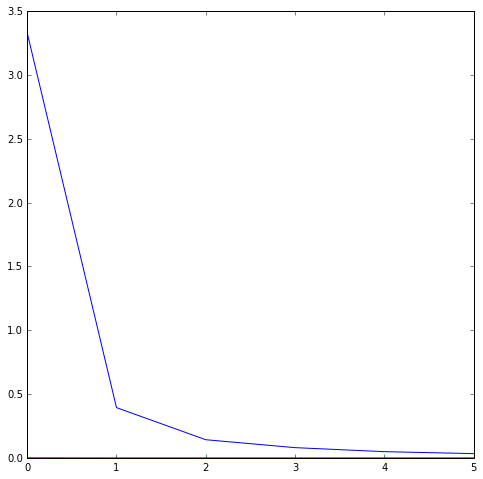

In [86]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [88]:
gen = generate_data_2(test_annotations[np.random.random_integers(0, test_annotations.size - 1, size=(100,))], C)

In [89]:
testdat = [t for t in gen]

In [90]:
Xtest, ytest = testdat[0]

In [91]:
out_fn = theano.function([yl.input], yl.output_test)

In [92]:
Xtest_out = out_fn(Xtest)

In [93]:
def draw_best(im, output):
    idx = (output[[4,9]]).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = max(0, xi), max(0, yi)
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    tmp = np.zeros((im.shape[0] + 10, im.shape[1] + 10) + im.shape[2:])
    tmp[5:-5,5:-5] = draw_im
    draw_im = tmp

    return draw_im, obj_score, class_score, coord

In [94]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [95]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [126]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a,b,c,d = draw_best(swap(Xtest[N]), Xtest_out[N])

52


In [130]:
Xtest_out[:,[4,9]].max()

5.7376244e-08

bike with class score: 0.605, objectness: 0.000
[ 0.19607051  0.13429058  0.60534054  0.06429832]
[  5.91808677e-01  -3.38346064e-01   3.77969831e-01   2.98476196e-04]


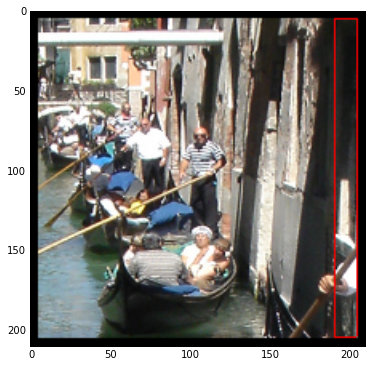

In [127]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
print c
print d

In [348]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)